
## This notebook reproduce figures of manuscript "Learning Wave Scattering Properties from Seismograms". 



The core idea is to look at the similiarity among sources in the subsurface and estimate complexity based on the local PCA-based dimensionality analysis 




In [1]:
import os
import sys

os.chdir("/bettik/dokhtdor/projects/scatnet4scatwaves")

import numpy as np
import scipy as sp
from tqdm import tqdm


import matplotlib.pyplot as plt
import proplot as pplt


from maincodes.sc_loader import *
from maincodes.umap_analysis import *

from scatseisnet import ScatteringNetwork
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler
import umap


In [32]:
freqmax = 8 # Maximum frequency to consider
sr = 40 # Sampling rate

reduce_type = np.median 

FIG_DIR = 'FIGURES_UMAP_SPACE'

DATAPATH = "/bettik/dokhtdor/projects/scatnet4scatwaves/data/dataset/"

FIG_PATH = f"/bettik/dokhtdor/projects/scatnet4scatwaves/figures/{FIG_DIR}/"
os.makedirs(FIG_PATH, exist_ok=True)

nx = 65
ny = 120

fontsize = 9

In [3]:
vs_hr = np.load(DATAPATH+'vs_map_2400x1300.npy') / 1000
vs_model = np.load(DATAPATH+'vs_array.npy') / 1000


data_records_vs = []
data_records_hs = []

for i in range(1, 6):
    data_read = np.hstack([np.load(DATAPATH+f"vert{i}/z_r_s{i}.npy")[:, np.newaxis,:], np.load(DATAPATH+f"horiz{i}/z_r_s{i}_hor.npy")[:, np.newaxis,:]] )    
    data_records_vs.append(data_read)
    
    data_read = np.hstack([np.load(DATAPATH+f"vert{i}/x_r_s{i}.npy")[:, np.newaxis,:], np.load(DATAPATH+f"horiz{i}/x_r_s{i}_hor.npy")[:, np.newaxis,:]] )    
    data_records_hs.append(data_read)

# convert to numpy arrays
data_records_vs = np.array(data_records_vs) 
data_records_hs = np.array(data_records_hs)

# Filter the data
data_records_vs = apply_sosfilter(data_records_vs[:,:,:],freq = freqmax, sr = sr, filter_type = 'lp')
data_records_hs = apply_sosfilter(data_records_hs[:,:,:], freq = freqmax, sr = sr, filter_type = 'lp')

# Reshape the data
data_records_vs = np.concatenate(data_records_vs, axis = 1)
data_records_hs = np.concatenate(data_records_hs, axis = 1)


In [4]:
x_dist = (10000+100*np.arange(nx))/1000
y_dist = (2500+100*np.arange(ny))/1000

index_vs = np.arange(nx*ny).reshape(ny, nx)

indx_visualization = [15, 35, 55, 75, 95]

x_dist_hr = np.arange(10, 16.5, .005)
y_dist_hr = np.arange(2.5, 14.5, .005)

time_ = np.arange(0, data_records_hs.shape[-1], 1) / sr


In [5]:
segment_duration_seconds = data_records_hs.shape[-1]/sr
samples_per_segment = int(segment_duration_seconds * sr)

bank_keyword_arguments = (
        {"octaves": 4, "resolution": 8, "quality": 2, "normalize_wavelet": 'l2'},
        {"octaves": 5, "resolution": 5, "quality": 2, "normalize_wavelet": 'l2'},
        )

network = ScatteringNetwork(
    *bank_keyword_arguments,
    bins=samples_per_segment,
    sampling_rate=sr,
    )

print(network)


ScatteringNetwork(bins=1500, sampling_rate=40, len=2)
ComplexMorletBank(bins=1500, octaves=4, resolution=8, quality=2, sampling_rate=40, len=32)
ComplexMorletBank(bins=1500, octaves=5, resolution=5, quality=2, sampling_rate=40, len=25)


/tmp/ipykernel_294051/4101422941.py:37: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()


/bettik/dokhtdor/projects/scatnet4scatwaves/figures/FIGURES_UMAP_SPACE/filterbank.png


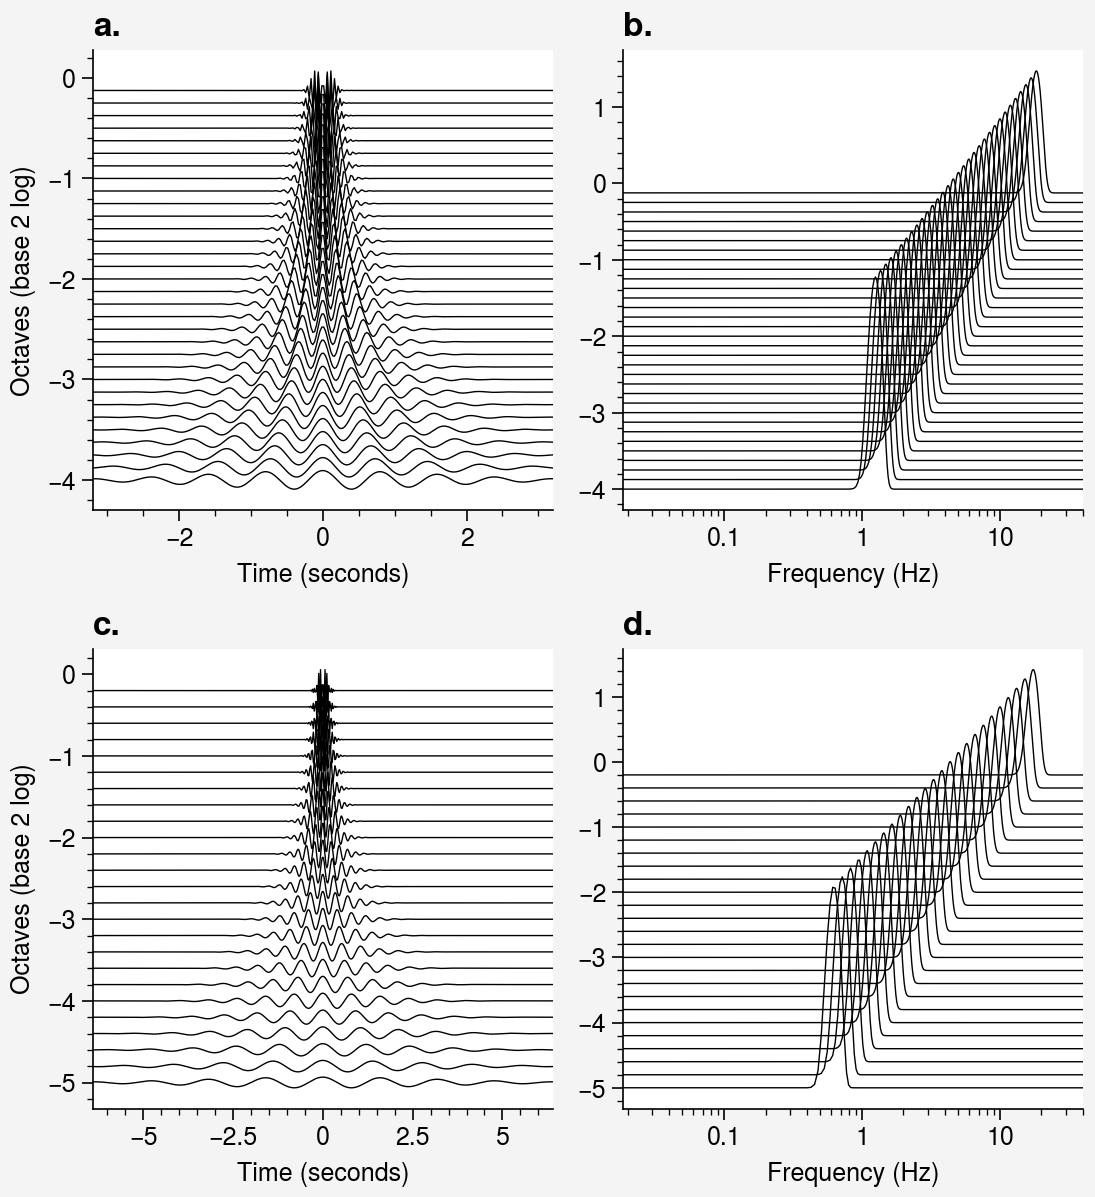

In [ ]:
fig = pplt.figure(refwidth=2.3, share=False)
ax = fig.subplots(ncols=2, nrows=2)

for i, bank in enumerate(network.banks):
    # Show each wavelet
    for wavelet, spectrum, ratio in zip(
        bank.wavelets[:], bank.spectra[:], bank.ratios[:]
        ):

        # Time domain
        ax[i,0].plot(
            bank.times, 
            wavelet.real + ratio, 
            c= 'k', 
            lw = 0.5,
            )
        
        ax[i,1].plot(
            bank.frequencies, 
            np.log(np.abs(spectrum) + 1) + ratio, 
            c = 'k', 
            lw = 0.5,
            )
        
    width_max = 2 * bank.widths.max()
    
    ax[i,0].set_ylabel("Octaves (base 2 log)")
    ax[i,0].set_xlabel("Time (seconds)")
    ax[i,0].set_xlim(-width_max, width_max)
    ax[i,0].grid()
    ax[i,1].set_xscale("log")
    ax[i,1].set_xlabel("Frequency (Hz)")
    ax[i,1].grid()
    
tit_ind = ['a', 'b', 'c', 'd', 'e', 'f']

for i, axn in enumerate(ax):
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    #ax.spines['bottom'].set_visible(False)
    #ax.spines['left'].set_visible(False)

    axn.set_title(f'{tit_ind[i]}.', loc = 'left', fontsize = 12, fontweight="bold")

PATH = FIG_PATH + f'filterbank.png'

fig.tight_layout()
fig.savefig(PATH, transparent=True, dpi = 300)
print(PATH)



In [7]:
segments = [data_records_hs[i,:,:] for i in index_vs[indx_visualization, 30]]
sc1 = network.transform(segments,  reduce_type= None )



In [8]:
sc_med__vs = "/bettik/dokhtdor/projects/scatnet4scatwaves/coefficients/sc_vs_4_median_40.npz"
sc_med__hs = "/bettik/dokhtdor/projects/scatnet4scatwaves/coefficients/sc_hs_4_median_40.npz"


scattering_coeff_vs = reader_coeff(sc_med__vs, network = network)
scattering_coeff_hs = reader_coeff(sc_med__hs, network = network)


In [9]:
scaler1 = [MinMaxScaler(feature_range = (-1, 1)), MinMaxScaler(feature_range = (-1, 1))]
scaler2 = [MinMaxScaler(feature_range = (-1, 1)), MinMaxScaler(feature_range = (-1, 1))]


#scaler = [RobustScaler(), RobustScaler()]

scattering_coef_vs_norm = preprocessing_(scattering_coeff_vs, scaler = scaler1)
scattering_coef_hs_norm = preprocessing_(scattering_coeff_hs, scaler = scaler2)



Normalization applied
Normalization applied


In [ ]:

UMAP_model = []
UMAP_space = []

for i, coeff_ in enumerate([scattering_coef_vs_norm, scattering_coef_hs_norm]):
    model_umap = umap.UMAP(
        n_neighbors = 40,
        min_dist = 0.0,
        n_components = 2,
        random_state = 42,
        metric = 'manhattan',
        #local_connectivity = 20
        )
    
    UMAP_space.append(model_umap.fit_transform(coeff_[:,320:]))
    UMAP_model.append(model_umap)
    
    print(f'UMAP for source {i} done')
    
    

/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP for source 0 done


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP for source 1 done


/tmp/ipykernel_294051/1933142762.py:48: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()


/bettik/dokhtdor/projects/scatnet4scatwaves/figures/FIGURES_UMAP_SPACE/UMAP_atlas_2.png


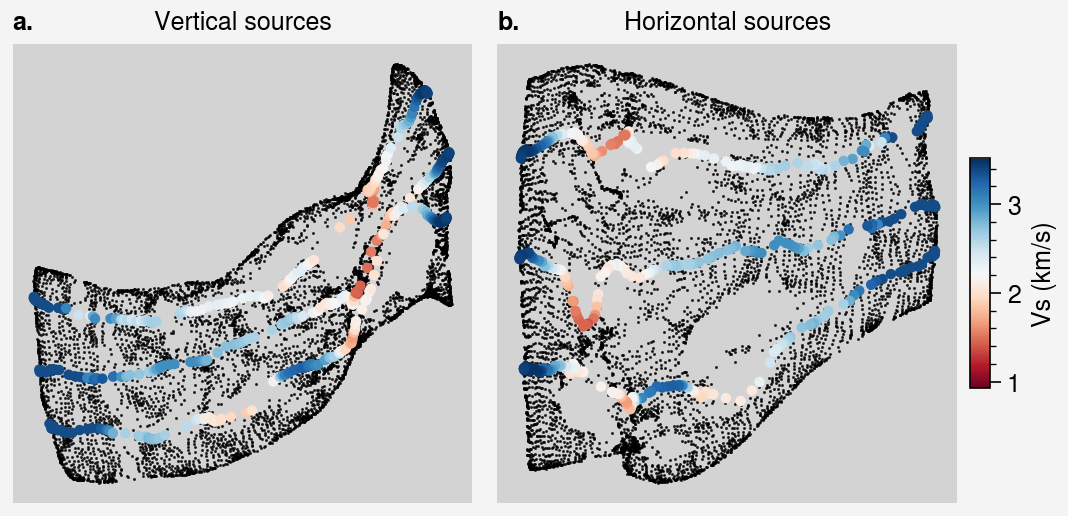

In [33]:
fig = pplt.figure(refwidth=2.3, share=False,)
axs = fig.subplots(ncols=2, nrows=1, axesfacecolor = 'lightgray')


vs_plotindex = [15, 30, 45]
alphabet_indx = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p']
NAME = ['Vertical sources', 'Horizontal sources']

for i, umap_data in enumerate(UMAP_space):
    ax = axs[i]
    im = ax.scatter(umap_data[:, 0], umap_data[:, 1],
                       c = 'k', s = 0.25, 
                       alpha = 0.75, rasterized=True
                       )
    
    for j in vs_plotindex:
        sc = ax.scatter(
            umap_data[index_vs[:, j], 0],
            umap_data[index_vs[:, j], 1],
            c=vs_model.reshape(-1)[index_vs[:, j]],
            vmin=vs_model.min(),
            vmax=vs_model.max(),
            cmap='RdBu',
            s=10,
            alpha=1,
            rasterized=True
        )
        
        if (j == 45) and (i == 1):
            ax.colorbar(sc, label='Vs (km/s)', width=0.1, length=0.5)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.set_facecolor('lightgray')  

    ax.set_title(f'{alphabet_indx[i]}.', loc = 'left', fontsize = fontsize, fontweight="bold")
    ax.set_title(NAME[i], fontsize = fontsize)


fig.tight_layout()
PATH = FIG_PATH + "UMAP_atlas_2" + ".png"

fig.savefig(
    PATH,
    bbox_inches="tight", 
    dpi=300, 
    transparent=False,
    )

print(PATH)


## PCA-based dimensionality analysis 


In [13]:
LOC_DIM = []

for i , umodel in enumerate(UMAP_model):
    
    print(f'UMAP for source {i}')
    LOC_DIM.append(calculate_local_dimension(umodel, threshold = 0.6))
    
    

UMAP for source 0


100%|██████████| 7800/7800 [02:06<00:00, 61.60it/s]


UMAP for source 1


100%|██████████| 7800/7800 [02:09<00:00, 60.35it/s]


/tmp/ipykernel_294051/760703335.py:27: ProplotWarning: Ignoring unused keyword arg(s): {'vmin': 5, 'vmax': 16}
  im1 = ax.imshow(
/tmp/ipykernel_294051/760703335.py:27: ProplotWarning: Ignoring unused keyword arg(s): {'vmin': 5, 'vmax': 16}
  im1 = ax.imshow(
/tmp/ipykernel_294051/760703335.py:53: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()


/bettik/dokhtdor/projects/scatnet4scatwaves/figures/FIGURES_UMAP_SPACE/UMAP_LOCAL_DIMENSIONALITY.png


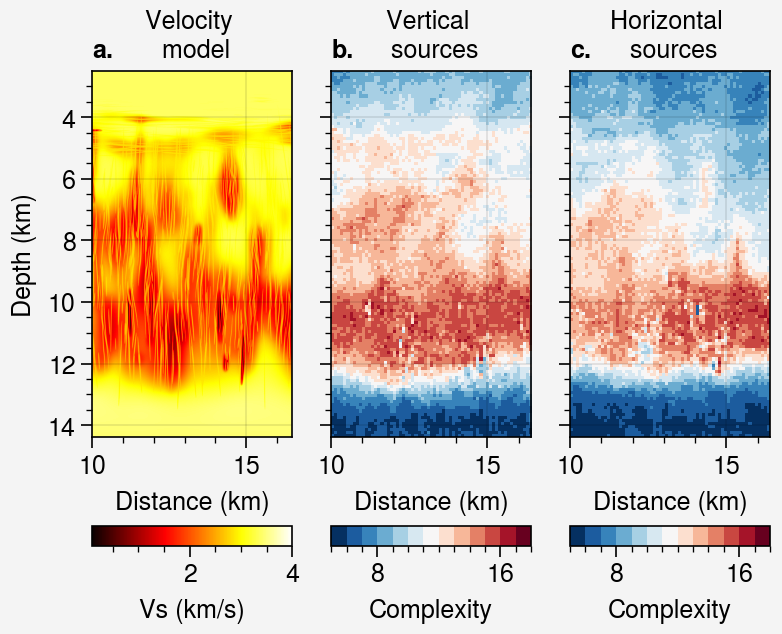

In [34]:
fig = pplt.figure(refwidth=1, sharey=True, sharex = False)
axs = fig.subplots(ncols=3, nrows=1)

NAME_TITLE = ['Velocity \n model', 'Vertical \n sources', 'Horizontal \n sources']

ax = axs[0]

im1 = ax.imshow(
    vs_hr, 
    extent = [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
    cmap = 'hot', 
    vmin = 0.1,
    vmax =4, 
    rasterized = True, 
    colorbar = 'b',
    colorbar_kw={'label':'Vs (km/s)', 'width':0.1},
    )

ax.set_ylim(y_dist.max(), y_dist.min())
ax.set_ylabel('Depth (km)')
ax.set_xlabel('Distance (km)')

for i, loc_dim in enumerate(LOC_DIM):
    
    levels = pplt.arange(np.min(loc_dim), np.max(loc_dim)+2, 1)
    ax = axs[i+1]
    im1 = ax.imshow(
        loc_dim.reshape(ny, nx), 
        cmap = 'RdBu_r', 
        vmin = loc_dim.min(), 
        vmax = loc_dim.max(), 
        extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()],
        aspect = 'auto', 
        rasterized = True,
        colorbar = 'b',
        colorbar_kw={'label':'Complexity', 'width':0.1},
        levels=levels,
        )


    ax.set_ylim(y_dist.max(), y_dist.min())
    ax.set_xlim(x_dist.min(), x_dist.max())
    ax.set_xlabel('Distance (km)')


for i, ax in enumerate(axs):
    ax.set_title(f'{alphabet_indx[i]}.', loc = 'left', fontsize = fontsize, fontweight="bold")
    ax.set_title(NAME_TITLE[i], fontsize= fontsize)


PATH = FIG_PATH + "UMAP_LOCAL_DIMENSIONALITY.png"

fig.tight_layout()

fig.savefig(
    PATH, 
    bbox_inches="tight", 
    dpi=300, 
    transparent=True,
    )

print(PATH)


In [15]:

def fft_(data, n):    
    nn = n//2
    return np.abs(np.fft.fft(data, n = n))[...,:nn], np.arange(nn)/(2*nn)


# Looking at the complexity first-order coefiicents and waveforms

/tmp/ipykernel_294051/1128862452.py:4: ProplotWarning: 'gridspec_kw' is not necessary in proplot. Pass the parameters as keyword arguments instead.
  axs = fig.subplots(ncols=3, nrows=2, gridspec_kw=gs)
/tmp/ipykernel_294051/1128862452.py:107: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()


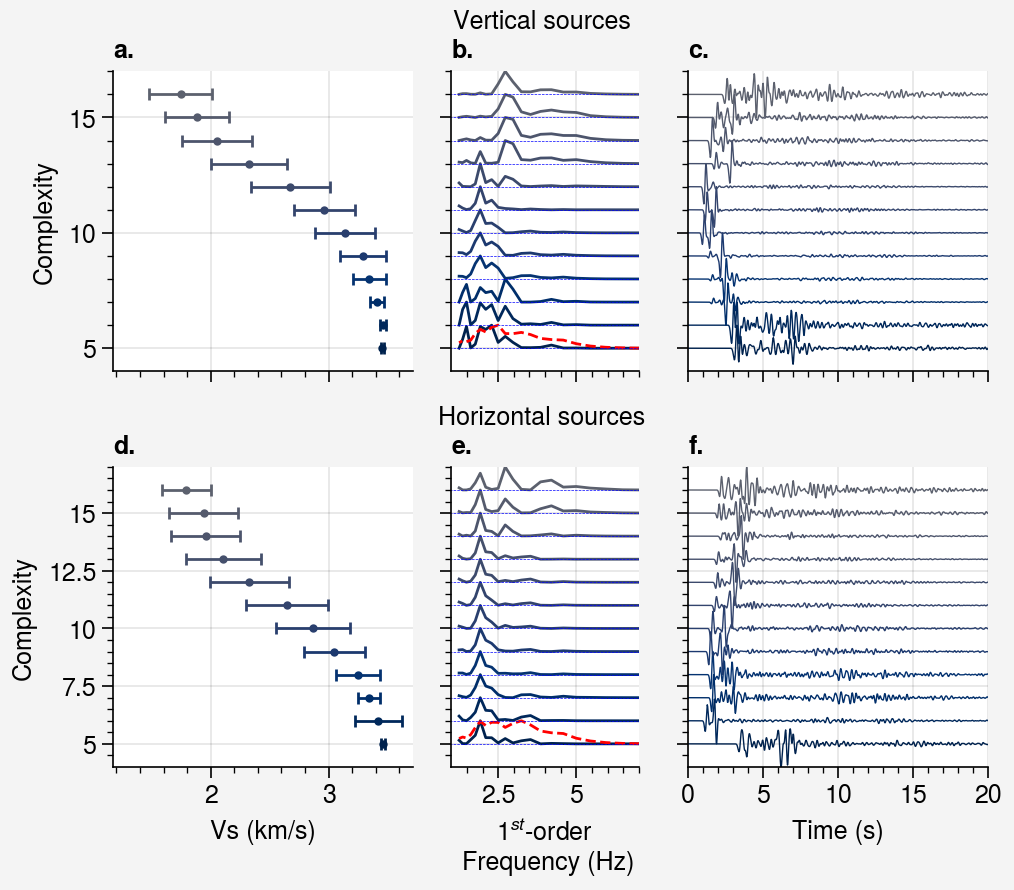

In [35]:
fig = pplt.figure(refwidth=1.5, sharey=True, sharex=True, span=False)

gs = {"width_ratios": [4,  2.5, 4]}
axs = fig.subplots(ncols=3, nrows=2, gridspec_kw=gs)

source_index = 4

for i, loc_dim, sc, data_records in zip(
    range(2),[LOC_DIM[0], LOC_DIM[1]], 
    [scattering_coeff_vs, scattering_coeff_hs], 
    [data_records_vs, data_records_hs]
    ):
    
    dim = np.unique(loc_dim[::1])
    cmap = plt.get_cmap('cividis', len(dim)+20)
    
    
    for j, dimen in enumerate(dim[::1]):

        indx = loc_dim == dimen
        vsselected = vs_model.reshape(-1)[indx]
        depth = np.repeat(y_dist, nx)[indx]
        
        dd = data_records[np.where(indx)[0]][:, :, :]
        
        dd = dd[0, source_index]/ np.max(abs(dd[0, source_index]))
    
        bplot = axs[i, 0].errorbar(
            np.mean(vsselected), 
            dimen, 
            xerr = np.std(vsselected),
            fmt = 'o', 
            lw =1 ,
            markersize = 2, 
            capsize = 2, 
            capthick = 1,
            c = cmap(j),
            )
        
        axs[i, 0].set_xlim(np.min(vs_model)+0.25, np.max(vs_model)+0.2)
        
        plo = np.mean(sc[0][:, :source_index:source_index+1,:], 0)
        
        sc_selected = np.mean(np.mean(sc[0][np.where(indx)[0]][:, source_index:source_index+1,:] - plo, axis =0), axis = 0)
        
        sc_selected = (sc_selected)**2
        sc_selected = sc_selected / np.max(abs(sc_selected))
        plo2 = np.mean(plo, 0)**2
        plo2 = plo2 /np.max(plo2)
        
        axs[i, 1].plot(
            network.banks[0].centers, 
            (sc_selected) + dimen,  
            lw = 1 , 
            c = cmap(j),
            )
        
        if j == 0:
              axs[i, 1].plot(
                  network.banks[0].centers, 
                  plo2 + dimen, 
                  lw = 1, 
                  c = 'r',
                  linestyle = '--',
                  )

        axs[i, 1].hlines(
            dimen, 
            0,
            network.banks[0].centers.max(),
            lw = 0.25, 
            linestyle = '--', 
            color = 'b',
            )

        axs[i, 1].set_xlim(1, 7)
        axs[i, 2].plot(
            time_,
            dd + dimen,
            c = cmap(j), 
            lw = 0.5,
            )

    axs[i, 0].set_ylim(dim[0]-1, dim[-1]+1) 
    axs[i, 1].set_ylim(dim[0]-1, dim[-1]+1) 
    axs[i, 2].set_ylim(dim[0]-1, dim[-1]+1) 
    axs[i, 2].set_xlim(0., 20)
    axs[i, 0].set_ylabel('Complexity')
    
    
axs[1, 0].set_xlabel('Vs (km/s)')
axs[1, 1].set_xlabel('$1^{st}$-order \n Frequency (Hz)')
axs[1, 2].set_xlabel('Time (s)')
axs[0, 1].set_title('Vertical sources \n', fontsize = fontsize)
axs[1, 1].set_title('Horizontal sources \n', fontsize = fontsize)


for i,  ax in enumerate(axs):    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title(alphabet_indx[i]+'.', loc = 'left', fontsize = fontsize, fontweight = 'bold')



PATH = FIG_PATH + "local_dimensionality_in_waveform.png"

fig.tight_layout()

fig.savefig(
    PATH,
    bbox_inches="tight",
    dpi=300, 
    transparent=True, 
    )


# Looking at the first and second-order scattering coefficents

/tmp/ipykernel_294051/1218378814.py:19: RuntimeWarning: Mean of empty slice
  sc_sel=np.nanmean(sc_sel, axis = 0)
/tmp/ipykernel_294051/1218378814.py:19: RuntimeWarning: Mean of empty slice
  sc_sel=np.nanmean(sc_sel, axis = 0)
/tmp/ipykernel_294051/1218378814.py:19: RuntimeWarning: Mean of empty slice
  sc_sel=np.nanmean(sc_sel, axis = 0)
/tmp/ipykernel_294051/1218378814.py:19: RuntimeWarning: Mean of empty slice
  sc_sel=np.nanmean(sc_sel, axis = 0)
/tmp/ipykernel_294051/1218378814.py:19: RuntimeWarning: Mean of empty slice
  sc_sel=np.nanmean(sc_sel, axis = 0)
/tmp/ipykernel_294051/1218378814.py:19: RuntimeWarning: Mean of empty slice
  sc_sel=np.nanmean(sc_sel, axis = 0)
/tmp/ipykernel_294051/1218378814.py:96: ProplotWarning: Got conflicting or duplicate keyword arguments: {'length': 0.5, 'shrink': 0.4}. Using the first keyword argument.
  fig.colorbar(im,
/tmp/ipykernel_294051/1218378814.py:105: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its 

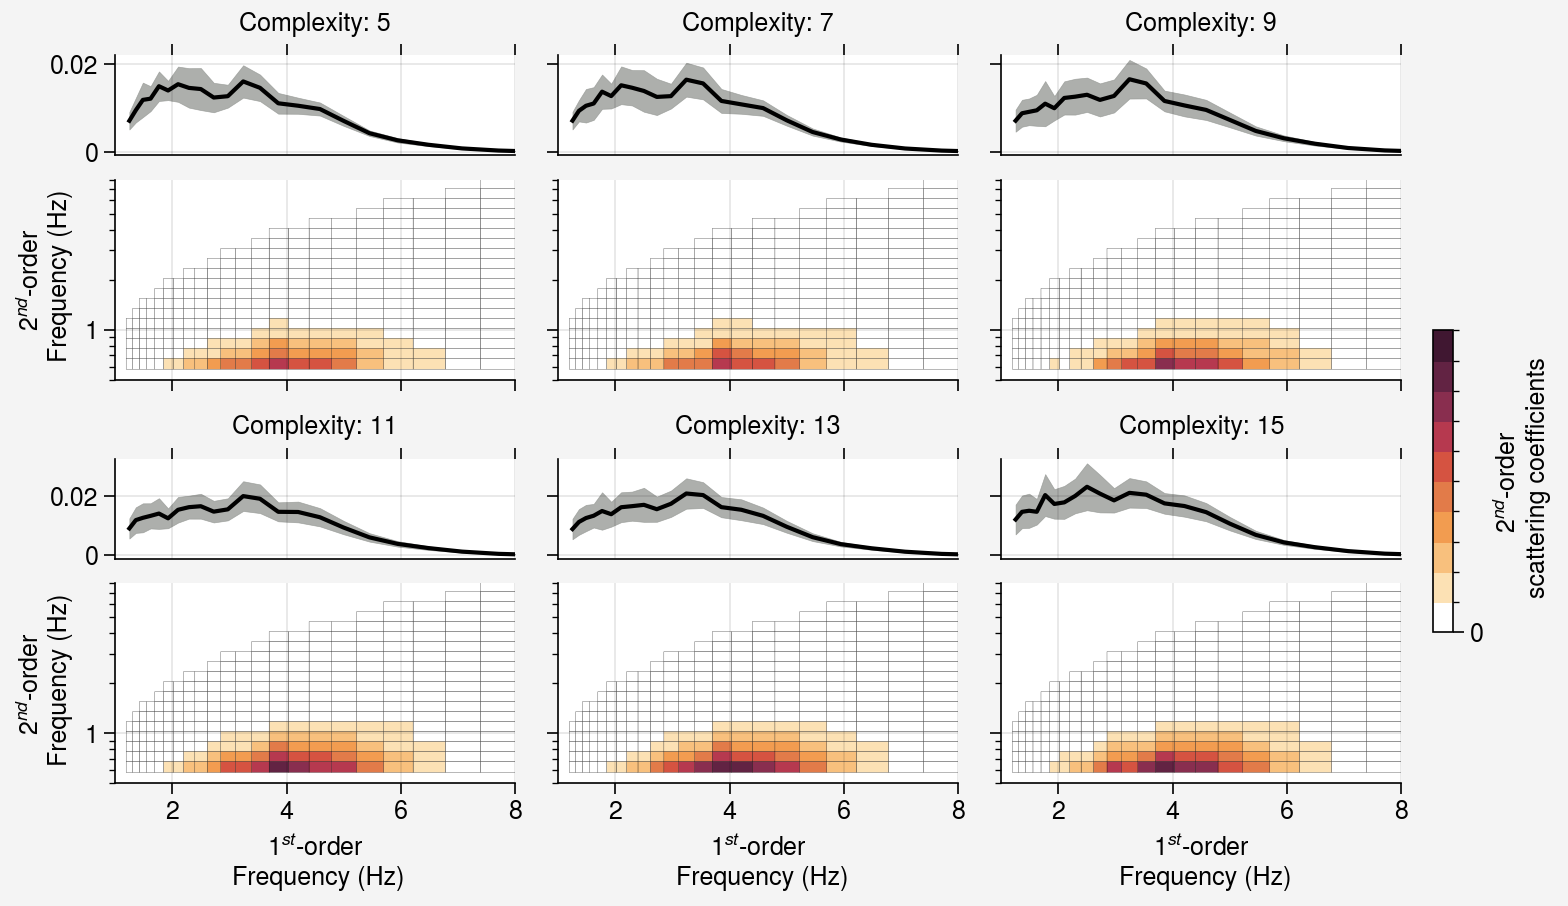

In [36]:

scc = scattering_coeff_vs[1][:, 5,:,:]
scc0 = scattering_coeff_vs[0][:,5,:]
#scc = np.nanmean(scc, axis = 1)
#scc0 = np.nanmean(scc0, axis = 1)


fig = pplt.figure( refwidth=2, refheight=1, sharex=True, sharey=True, span=False)
gs = {"height_ratios": [1, 1, 1]}
axs=fig.subplots(ncols=3, nrows=2, )

ii = 0
loc_index=np.unique(LOC_DIM[0])[::2]

for i, loc_d_val in enumerate(loc_index):
    index = np.where(LOC_DIM[0]==loc_d_val)[0]
    sc_sel=abs(scc[index][:,...])
    
    sc_sel=sc_sel#-np.nanmean(scc, axis = 0, keepdims = True)  
    sc_sel=np.nanmean(sc_sel, axis = 0)
    
    im=axs[ii].pcolor(network.banks[0].centers, 
                   network.banks[1].centers, 
                   sc_sel.T,
                   rasterized=True, 
                   edgecolors='k', 
                   linewidths=0.1,
                   vmin=0,
                   vmax=0.04,
                   )
    
    axs[ii].set_yscale('log')
    #axs[ii].set_xscale('log')

    #axs[ii].axis('off')
    axs[ii].set_xlim(1, 8)
    axs[ii].set_ylim(0.5, 8)
    axs[ii].set_title(f'Complexity: {loc_d_val}', fontsize = fontsize)


    pax = axs[ii].panel_axes('t')
    
    sc_sel_=scc0[index]
    sc_sel=sc_sel_[:,...]#-np.nanmean(scc, axis = 0, keepdims = True)  
    sc_sel_std = np.nanstd(sc_sel_, axis = 0)
    sc_sel=np.nanmean(sc_sel, axis = 0)
        
    # pax.plot(network.banks[0].centers,
    #          sc_sel_.T, 
    #          lw = 0.25, 
    #          alpha =0.5,
    #          rasterized=True,
    #          )
    
    pax.fill_between(
        network.banks[0].centers,
        sc_sel - sc_sel_std, 
        sc_sel + sc_sel_std,
        lw = 0.25, 
        alpha =0.75,
        color = 'gray',
        rasterized=True,
        )
    
    
    pax.plot(network.banks[0].centers,
             sc_sel, 
             rasterized=True,
             c='k',
             
             )
            
    #pax.set_ylim(0, 0.02)
    pax.set_xlim(1, 8)

    pax.spines['top'].set_visible(False)
    pax.spines['right'].set_visible(False)
    
    pax.minorticks_off()

    
    ii+=1
    
    
for axn in axs:
    axn.spines['top'].set_visible(False)
    axn.spines['right'].set_visible(False)
    axn.set_xlim(1, 8)
    
axs[0].set_ylabel('$2^{nd}$-order \n Frequency (Hz)')
axs[3].set_ylabel('$2^{nd}$-order \n Frequency (Hz)')
axs[-1].set_xlabel('$1^{st}$-order \n Frequency (Hz)')
axs[-2].set_xlabel('$1^{st}$-order \n Frequency (Hz)')
axs[-3].set_xlabel('$1^{st}$-order \n Frequency (Hz)')


fig.colorbar(im, 
             width=0.1,
             shrink=0.4,
             length =0.5, 
             label='$2^{nd}$-order \n scattering coefficients', 
             locator = 5)

PATH = FIG_PATH + "second_order.png"

fig.tight_layout()

fig.savefig(
    PATH, 
    bbox_inches="tight", 
    dpi=300,
    transparent=True, 
    )



# Comparision with statistical properties of medium

In [18]:
corr_length_data = np.load('/bettik/dokhtdor/projects/scatnet4scatwaves/data/data_processed/corr_length.npy')
std_mean_ = np.load('/bettik/dokhtdor/projects/scatnet4scatwaves/data/data_processed/std_mean_500m.npy')
corr_smooth = sp.ndimage.gaussian_filter(corr_length_data, 0.8)


/tmp/ipykernel_294051/1659765424.py:4: ProplotWarning: 'gridspec_kw' is not necessary in proplot. Pass the parameters as keyword arguments instead.
  axs = fig.subplots(ncols=2, nrows=2, gridspec_kw=gs)


/tmp/ipykernel_294051/1659765424.py:72: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()


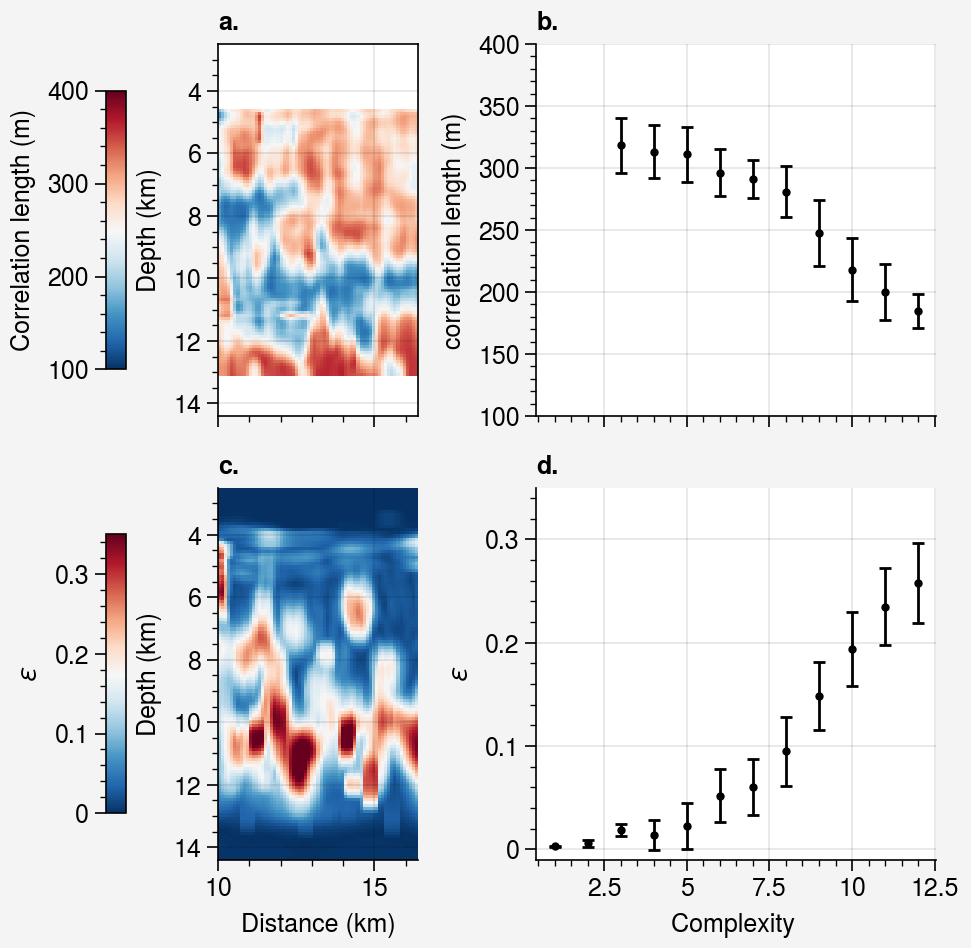

In [37]:
fig = pplt.figure( sharey=False, sharex=True, refwidth=1, span=False)

gs = {"width_ratios": [0.5, 1]}
axs = fig.subplots(ncols=2, nrows=2, gridspec_kw=gs)

locdim = LOC_DIM[0]
dim = np.unique(LOC_DIM[0])
cmaaps = ['RdBu_r', 'RdBu_r']

for i, par, title, cvalues in zip([0, 2], [corr_smooth, std_mean_], ['Correlation length (m)', '$\epsilon$'], [[100, 400], [0,0.35]]):
    ax = axs[i]
    im1 = ax.imshow(
        par, 
        cmap = cmaaps[0], 
        extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()], 
        rasterized = True, 
        vmin = cvalues[0], 
        vmax = cvalues[1], 
        colorbar = 'l', 
        colorbar_kw={'width':0.1,  'label': title, 'length': 0.75}, 
        )

    for j, dimen in enumerate(dim[::1]):
        
        qw = par.reshape(-1)[np.where(locdim==dimen)[0]]
        depth = np.repeat(y_dist, 65)[np.where(locdim==dimen)[0]]
        depth = depth[~np.isnan(qw)]
        qw = qw[~np.isnan(qw)]
        
        if len(qw) > 5:
            ax = axs[i+1]
            bplot = ax.errorbar(
                j+1, 
                np.mean(qw), 
                yerr = np.std(qw)/2, 
                fmt = 'o', 
                lw =1, 
                markersize = 2, 
                capsize = 2, 
                capthick = 1,
                c = 'k',
                rasterized = True, 
                )


axs[0, 0].set_ylabel('Depth (km)')
axs[1, 0].set_ylabel('Depth (km)')
axs[1, 0].set_xlabel('Distance (km)')


axs[0, 1].set_ylim(100, 400)
axs[1, 1].set_ylim(-0.01, 0.35)


axs[0, 1].set_ylabel('correlation length (m)')

axs[0, 1].set_xlabel('Complexity ')
axs[1, 1].set_xlabel('Complexity ')
axs[1, 1].set_ylabel('$\epsilon$')


for ax in axs[:,1]:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)


for i, ax in enumerate(axs):
    ax.set_title(f'{alphabet_indx[i]}.', loc = 'left', fontsize = fontsize, fontweight="bold")

PATH = FIG_PATH + "correlation_length_vs_local_dim_all.png"

fig.tight_layout()

fig.savefig(
    PATH, 
    bbox_inches="tight", 
    dpi=300, 
    transparent=True, 
    )



# Mapping the local complexity in source positions


/tmp/ipykernel_294051/3909461489.py:56: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()


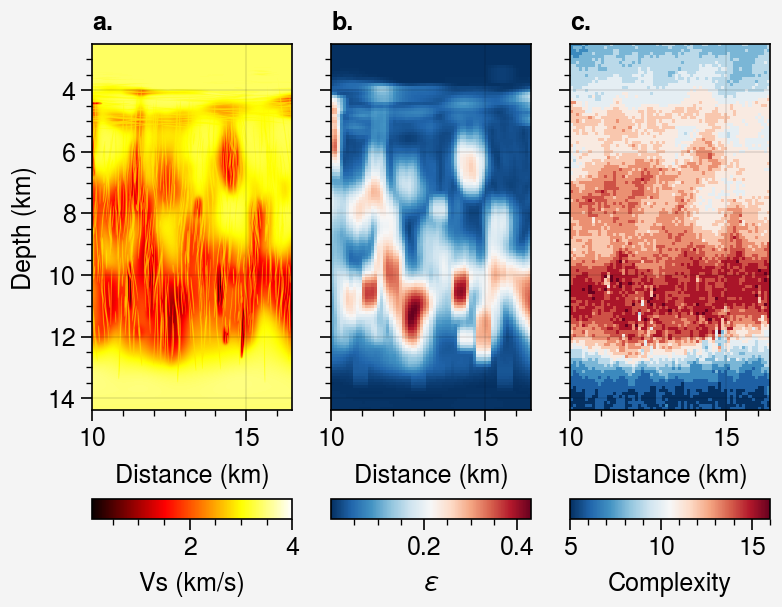

In [38]:
fig = pplt.figure(refwidth=1, sharey=True, sharex = False)
axs = fig.subplots(ncols=3, nrows=1)

ax = axs[0]
im1 = ax.imshow(
    vs_hr, 
    extent = [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
    cmap = 'hot',
    vmin = 0.1, 
    vmax =4, 
    rasterized = True, 
    colorbar = 'b',
    colorbar_kw={'label':'Vs (km/s)', 'width':0.1}, 
    )

ax.set_ylim(y_dist.max(), y_dist.min())
ax.set_ylabel('Depth (km)')
ax.set_xlabel('Distance (km)')

ax = axs[1]
im1 = ax.imshow(
    std_mean_, 
    extent = [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
    cmap = 'RdBu_r',
    rasterized = True, 
    colorbar = 'b', 
    colorbar_kw={'label':'$\epsilon$', 'width':0.1},
    )

ax.set_ylim(y_dist.max(), y_dist.min())
ax.set_xlabel('Distance (km)')

ax = axs[2]
loc_dim = LOC_DIM[0]

im1 = ax.imshow(
    loc_dim.reshape(ny, nx), 
    cmap = 'RdBu_r', 
    vmin = loc_dim.min(), 
    vmax = loc_dim.max(), 
    extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()],
    aspect = 'auto', 
    rasterized = True,
    colorbar = 'b',
    colorbar_kw={'label':'Complexity', 'width':0.1},
    )

ax.set_ylim(y_dist.max(), y_dist.min())
ax.set_xlabel('Distance (km)')

for i, ax in enumerate(axs):
    ax.set_title(f'{tit_ind[i]}.', loc = 'left', fontsize = fontsize, fontweight="bold")

PATH = FIG_PATH + "velocity_model_correlation_length_local_dim_all.png"

fig.tight_layout()

fig.savefig(
    PATH, 
    bbox_inches="tight", 
    dpi=300, 
    transparent=True, 
    )


# Hyperparameter test in UMAP space


In [45]:
UMAPS_MODEL_HYPERPAR = []
UMAP_SPACE_HYPERPAR = []

k_neighbors = [10 , 30, 50, ]
min_distances = [0.1, 0.5, 0.9]

for i, neighbor in enumerate(k_neighbors):        
    model_u = []
    space_u = []
    
    for j, mindis in enumerate(min_distances):    
        print(f'Model number {i}, {j}: UMAP calculation for k-nn = {neighbor}, min_dis = {mindis}')
        
        # Initialize uMAP for each hyperparameter
        umodel = umap.UMAP(
            densmap=False, 
            n_neighbors = neighbor,
            min_dist = mindis,
            n_components = 2,
            random_state = 42, 
            metric = 'manhattan', 
            # local_connectivity = 20,
            )
        
        space_u.append(umodel.fit_transform(scattering_coef_vs_norm))
        model_u.append(umodel)
                
    UMAPS_MODEL_HYPERPAR.append(model_u)
    UMAP_SPACE_HYPERPAR.append(space_u)


Model num 0, 0: UMAP calculation for k-nn = 10, min_dis = 0.1


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Model num 0, 1: UMAP calculation for k-nn = 10, min_dis = 0.5


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Model num 0, 2: UMAP calculation for k-nn = 10, min_dis = 0.9


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Model num 1, 0: UMAP calculation for k-nn = 30, min_dis = 0.1


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Model num 1, 1: UMAP calculation for k-nn = 30, min_dis = 0.5


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Model num 1, 2: UMAP calculation for k-nn = 30, min_dis = 0.9


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Model num 2, 0: UMAP calculation for k-nn = 50, min_dis = 0.1


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Model num 2, 1: UMAP calculation for k-nn = 50, min_dis = 0.5


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Model num 2, 2: UMAP calculation for k-nn = 50, min_dis = 0.9


/home/dokhtdor/.conda/envs/scatnet_tremors/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


/tmp/ipykernel_294051/2745000368.py:9: ProplotWarning: Ignoring unused keyword arg(s): {'cmap': 'RdBu'}
  im = ax.scatter(
/tmp/ipykernel_294051/2745000368.py:49: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()


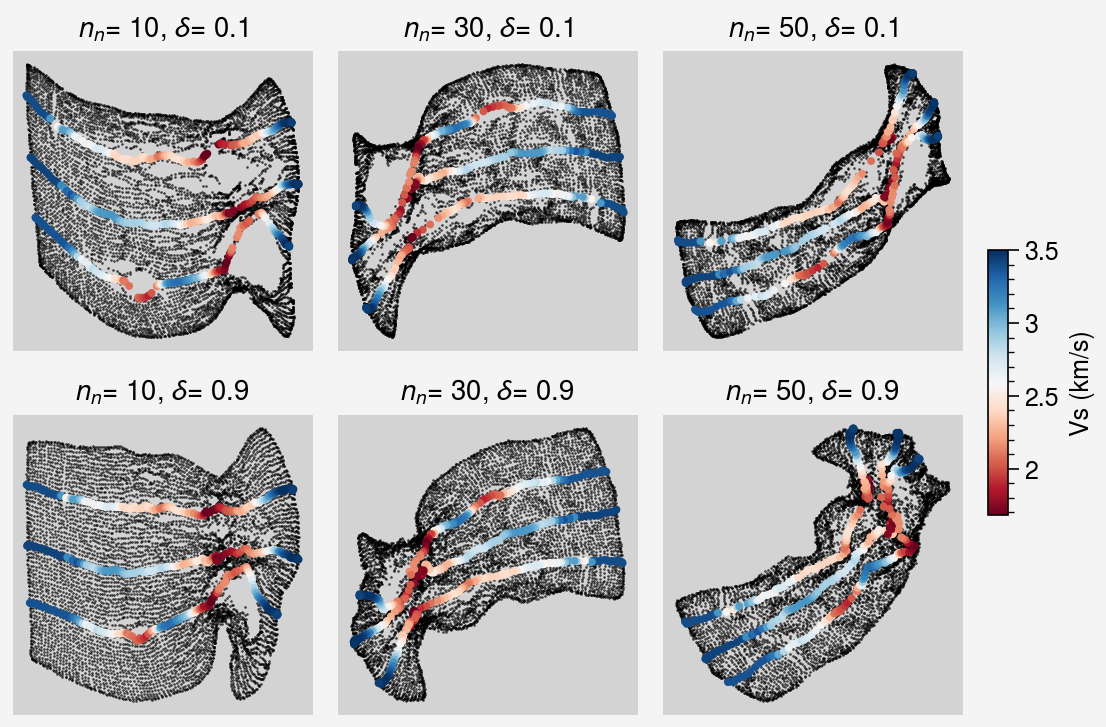

In [46]:
fig = pplt.figure( sharey=False, sharex=False, refwidth=1.5,)

axs = fig.subplots(ncols=3, nrows=2,)

for i, knn in enumerate(k_neighbors):
    for j, mdin in enumerate(min_distances[::2]):
        ax = axs[j, i]
        
        im = ax.scatter(
            UMAP_SPACE_HYPERPAR[i][j][:, 0], 
            UMAP_SPACE_HYPERPAR[i][j][:, 1], 
            c = 'k', 
            cmap = 'RdBu', 
            s = 0.1, 
            alpha = 0.75, 
            rasterized=True, 
            )
        
        for k in vs_plotindex:
            im = ax.scatter(
                UMAP_SPACE_HYPERPAR[i][j][index_vs[:, k], 0], 
                UMAP_SPACE_HYPERPAR[i][j][index_vs[:, k], 1], 
                c = vs_model.reshape(-1)[index_vs[:, k]], 
                cmap = 'RdBu',
                s = 5, 
                alpha = 1, 
                rasterized=True,
                )
            
        ax.set_title('$n_{n}$' +f'= {knn}, ' +  '$\delta$'+ f'= {mdin}')

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        ax.set_facecolor('lightgray') 
        

fig.colorbar(im, width = 0.1, shrink=0.4, label = 'Vs (km/s)')

PATH = FIG_PATH + "UMAP_hyperparameters.png"

fig.tight_layout()

fig.savefig(
    PATH, 
    bbox_inches="tight",
    dpi=300, 
    transparent=False,
    )


# Hyperparameter test in local PCA-based dimensionality analysis


In [47]:
LOC_DIM_HYPERPAR = []
varaince_threshold = [0.45, 0.7, 0.9]

for i in (range(len(k_neighbors))):
    loc_dim_hyp = []
    for j in range(len(varaince_threshold)):
        
        print(f"Model number {i}, {j}: Local dimensionality for k-nn = 
              {k_neighbors[i]}, min_dis = {min_distances[0]}, 
              variance = {varaince_threshold[j]}")
    
        loc_dim_hyp.append(
            calculate_local_dimension(
                UMAPS_MODEL_HYPERPAR[i][0], 
                threshold = varaince_threshold[j]
                )
            )
            
    LOC_DIM_HYPERPAR.append(loc_dim_hyp)
    

Model number 0, 0: Local dimensionality for k-nn = 10, min_dis = 0.1, variance = 0.45


100%|██████████| 7800/7800 [00:19<00:00, 409.07it/s]


Model number 0, 1: Local dimensionality for k-nn = 10, min_dis = 0.1, variance = 0.7


100%|██████████| 7800/7800 [00:18<00:00, 410.95it/s]


Model number 0, 2: Local dimensionality for k-nn = 10, min_dis = 0.1, variance = 0.9


100%|██████████| 7800/7800 [00:19<00:00, 407.14it/s]


Model number 1, 0: Local dimensionality for k-nn = 30, min_dis = 0.1, variance = 0.45


100%|██████████| 7800/7800 [01:29<00:00, 86.83it/s]


Model number 1, 1: Local dimensionality for k-nn = 30, min_dis = 0.1, variance = 0.7


100%|██████████| 7800/7800 [01:30<00:00, 86.56it/s]


Model number 1, 2: Local dimensionality for k-nn = 30, min_dis = 0.1, variance = 0.9


100%|██████████| 7800/7800 [01:28<00:00, 88.46it/s]


Model number 2, 0: Local dimensionality for k-nn = 50, min_dis = 0.1, variance = 0.45


100%|██████████| 7800/7800 [03:12<00:00, 40.54it/s]


Model number 2, 1: Local dimensionality for k-nn = 50, min_dis = 0.1, variance = 0.7


100%|██████████| 7800/7800 [03:12<00:00, 40.48it/s]


Model number 2, 2: Local dimensionality for k-nn = 50, min_dis = 0.1, variance = 0.9


100%|██████████| 7800/7800 [03:10<00:00, 40.92it/s]


/tmp/ipykernel_294051/3210976221.py:37: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()


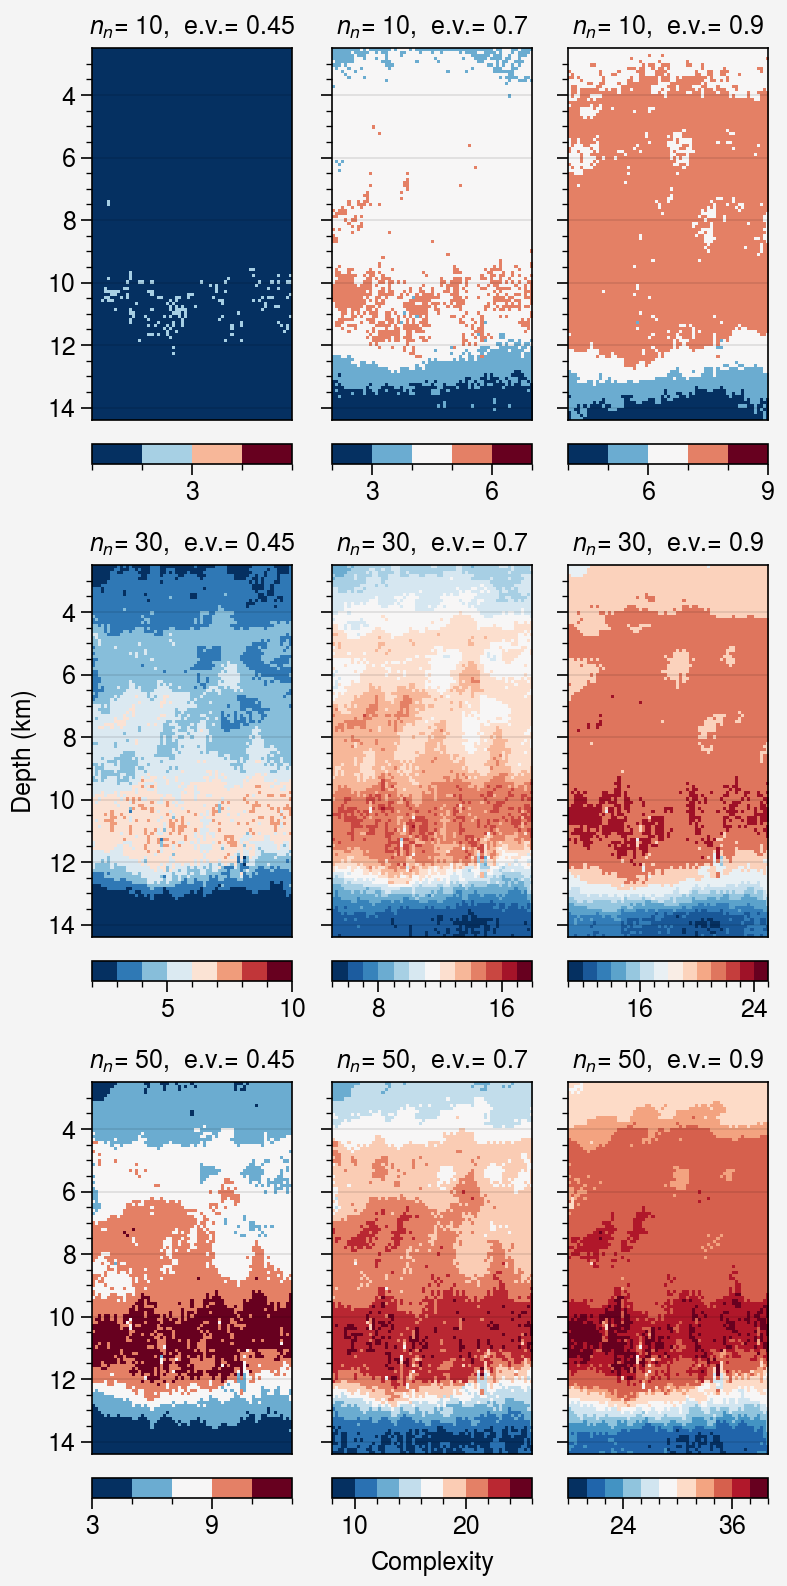

In [48]:
fig = pplt.figure(  sharey=True, sharex=True, refwidth=1.)
axs = fig.subplots(ncols=3, nrows=3,  order='F')

for i, knn in enumerate(k_neighbors):
    for j, var in enumerate(varaince_threshold):
                
        ax = axs[i, j]
        
        locdim = LOC_DIM_HYPERPAR[i][j]
        ncl = np.max(locdim) - np.min(locdim) + 1
        levels = pplt.arange(np.min(locdim), np.max(locdim)+2, 1+i//2)
        
        cmap = pplt.Colormap('RdBu_r')
        
        [label := 'Complexity' if ((j == 1) and (i == 2)) else '']
        
        im = ax.imshow(
            locdim.reshape(ny, nx), 
            rasterized = True,  
            cmap = cmap,
            levels=levels, 
            colorbar = 'b', 
            colorbar_kw={'label': label, "width" : 0.1},
            extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()], 
            )
        
        ax.set_title('$n_{n}$' +f'= {knn}, ' +  ' e.v.'+ f'= {var}', fontsize = 9)
        ax.set_ylim(y_dist.max(), y_dist.min())
        ax.set_xlim(x_dist.min(), x_dist.max())
        
        ax.set_ylabel('Depth (km)')
        ax.set_xticks([])

        
PATH = FIG_PATH + "UMAP_hyperparameters_dimensionality.png"

fig.tight_layout()

fig.savefig(
    PATH, 
    bbox_inches="tight", 
    dpi=300, 
    transparent=True,
    )


# Look at the complexity around real position of sources


In [26]:

threshold = 0.8
radii = 3
loc_dim_in_model = []

for data in [scattering_coef_vs_norm, scattering_coef_hs_norm]:
    local_dim_ = calculate_local_dimensionality_in_model(
        data, 
        vs_model.shape, 
        radii = radii, 
        threshold = threshold, 
        )
    
    loc_dim_in_model.append(local_dim_)
    
    

100%|██████████| 120/120 [03:14<00:00,  1.62s/it]


/tmp/ipykernel_294051/1035837063.py:27: ProplotWarning: Ignoring unused keyword arg(s): {'vmin': 7, 'vmax': 29}
  im1 = ax.imshow(
/tmp/ipykernel_294051/1035837063.py:27: ProplotWarning: Ignoring unused keyword arg(s): {'vmin': 8, 'vmax': 28}
  im1 = ax.imshow(
/tmp/ipykernel_294051/1035837063.py:51: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()


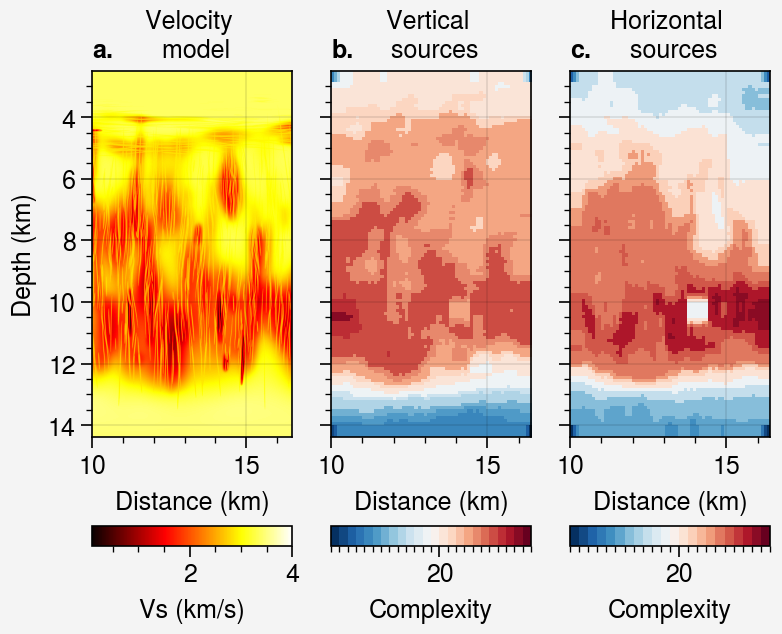

In [41]:
fig = pplt.figure(refwidth=1, sharey=True, sharex = False)
axs = fig.subplots(ncols=3, nrows=1)

NAME_TITLE = ['Velocity \n model', 'Vertical \n sources', 'Horizontal \n sources']

ax = axs[0]
im1 = ax.imshow(
    vs_hr, 
    cmap= 'hot', 
    vmin = 0.1, 
    vmax =4, 
    rasterized= True, 
    colorbar = 'b', 
    colorbar_kw={'label':'Vs (km/s)', 'width':0.1}, 
    extent= [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
    )

ax.set_ylim(y_dist.max(), y_dist.min())
ax.set_ylabel('Depth (km)')
ax.set_xlabel('Distance (km)')


for i, loc_dim in enumerate(loc_dim_in_model):
      
    levels = pplt.arange(np.min(loc_dim), np.max(loc_dim)+2, 1)
    ax = axs[i+1]
    im1 = ax.imshow(
        loc_dim.reshape(120, 65), 
        cmap= 'RdBu_r', 
        vmin= loc_dim.min(), 
        vmax= loc_dim.max(), 
        aspect= 'auto', 
        rasterized= True,
        colorbar= 'b',
        levels= levels, 
        extent= [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()],
        colorbar_kw= {'label':'Complexity', 'width':0.1}, 
        )

    ax.set_ylim(y_dist.max(), y_dist.min())
    ax.set_xlim(x_dist.min(), x_dist.max())
    ax.set_xlabel('Distance (km)')
    
    
for i, ax in enumerate(axs):
    ax.set_title(f'{tit_ind[i]}.', loc = 'left', fontsize = fontsize, fontweight="bold")
    ax.set_title(NAME_TITLE[i], fontsize = fontsize)
    
PATH = FIG_PATH + "LOCAL_DIMENSIONALITY_in_model.png"

fig.tight_layout()

fig.savefig(
    PATH,
    bbox_inches="tight",
    dpi=300,
    transparent=True,
    )



### Estimating Entropy of scattering coefficient instead of complexity 


In [29]:
threshold = 0.8

entropy_in_model = []

for dd in [scattering_coef_vs_norm, scattering_coef_hs_norm]:
    
    local_entropy = calculate_local_entropy_in_model(
        dd, 
        vs_model.shape, 
        radii = radii,
        )
    
    entropy_in_model.append(local_entropy)
        

100%|██████████| 120/120 [03:02<00:00,  1.52s/it]


/tmp/ipykernel_294051/4260373631.py:43: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()


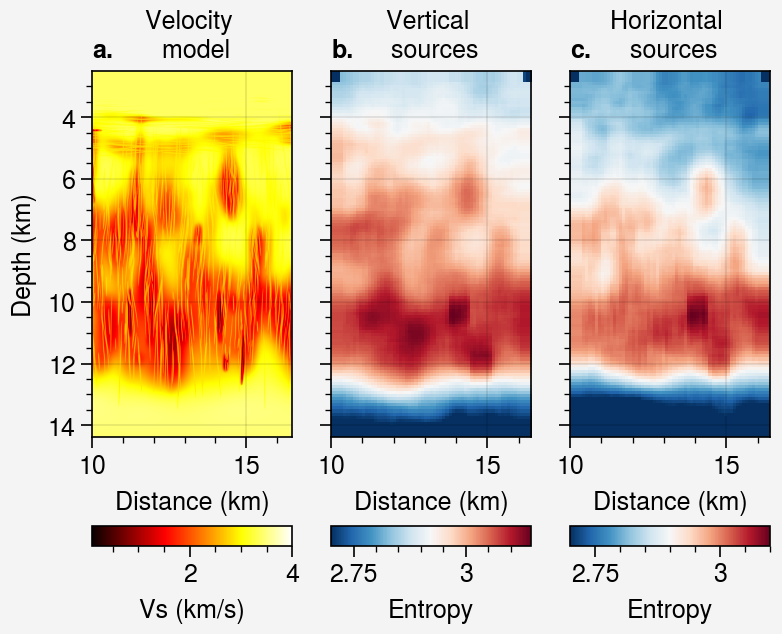

In [53]:
fig = pplt.figure(refwidth=1, sharey=True, sharex = False)
axs = fig.subplots(ncols=3, nrows=1)

NAME_TITLE = ['Velocity \n model', 'Vertical \n sources', 'Horizontal \n sources']

ax = axs[0]
im1 = ax.imshow(
    vs_hr, 
    cmap = 'hot',
    vmin = 0.1,
    vmax =4, 
    rasterized = True, 
    colorbar = 'b', 
    colorbar_kw={'label':'Vs (km/s)', 'width':0.1}, 
    extent = [x_dist_hr.min(), x_dist_hr.max(), y_dist_hr.max(), y_dist_hr.min()],
    )

ax.set_ylim(y_dist.max(), y_dist.min())
ax.set_ylabel('Depth (km)')
ax.set_xlabel('Distance (km)')

for i, loc_dim in enumerate(entropy_in_model):    
    ax = axs[i+1]
    im1 = ax.imshow(
        loc_dim.reshape(ny, nx), 
        cmap = 'RdBu_r', 
        aspect = 'auto', 
        rasterized = True,
        colorbar = 'b',
        colorbar_kw={'label':'Entropy', 'width':0.1}, 
        extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()],
        vmin = 2.7,
        )

    ax.set_ylim(y_dist.max(), y_dist.min())
    ax.set_xlim(x_dist.min(), x_dist.max())
    ax.set_xlabel('Distance (km)')

for i, ax in enumerate(axs):
    ax.set_title(f'{tit_ind[i]}.', loc = 'left', fontsize = fontsize, fontweight="bold")
    ax.set_title(NAME_TITLE[i], fontsize = fontsize)
    
fig.tight_layout()
    
PATH = FIG_PATH + "entropy_in_model.png"

fig.savefig(
    PATH,
    bbox_inches="tight", 
    dpi=300, 
    transparent=True,
    )


In [43]:
LOCAL_ENTROPY_HYPER = []

for i in (range(len(k_neighbors))):
    
    LOCAL_ENTROPY_HYPER.append(calculate_entropy_in_umap(UMAPS_MODEL_HYPERPAR[i][0], scattering_coef_vs_norm))
    
    

100%|██████████| 7800/7800 [03:03<00:00, 42.59it/s]


/tmp/ipykernel_294051/3477016694.py:28: ProplotWarning: fig.tight_layout() has no effect on proplot figures. Proplot uses its own tight layout algorithm that is activated by default. To disable it, set pplt.rc['subplots.tight'] to False or pass tight=False to pplt.subplots(). For details, see fig.auto_layout().
  fig.tight_layout()


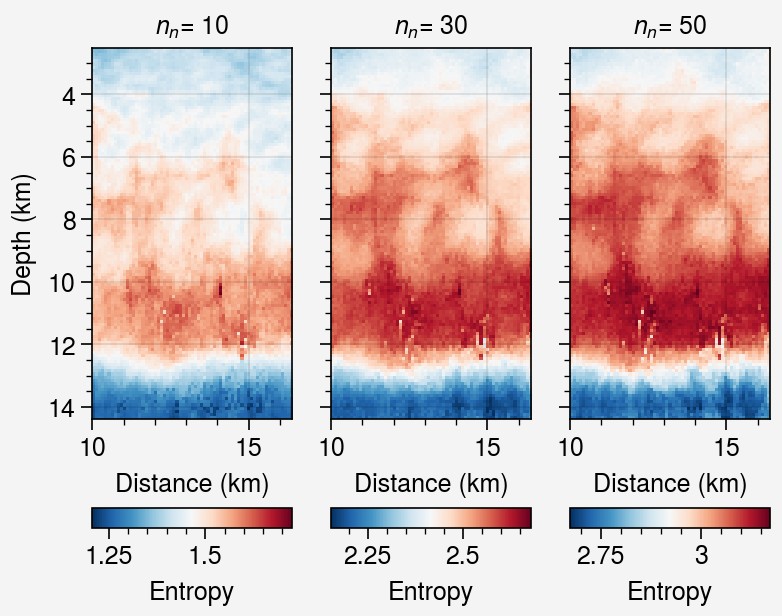

In [ ]:
fig = pplt.figure(refwidth=1, sharey=True, sharex = False)
axs = fig.subplots(ncols=3, nrows=1)
cmap = 'RdBu_r'

for i, knn in enumerate(k_neighbors):
            
    locdim = LOCAL_ENTROPY_HYPER[i]    
    ax = axs[i]
    
    sc = ax.imshow(
        locdim.reshape(ny, nx), 
        cmap = cmap, 
        rasterized = True,
        colorbar = 'b', 
        colorbar_kw = {'label': 'Entropy', 'width': 0.1}, 
        extent = [x_dist.min(), x_dist.max(), y_dist.max(), y_dist.min()],
        # vmin = 2.5,
        )
    
    ax.set_ylim(y_dist.max(), y_dist.min())
    ax.set_xlim(x_dist.min(), x_dist.max())
    ax.set_xlabel('Distance (km)')
    ax.set_title('$n_{n}$' +f'= {knn}', fontsize = fontsize)

axs[0].set_ylabel('Depth (km)')

fig.tight_layout()

PATH = FIG_PATH + "UMAP_LOCAL_ENTROLPY_hyperpar.png"

fig.savefig(
    PATH, 
    bbox_inches="tight", 
    dpi=300, 
    transparent=True,
    )

